## READ ME:

This is a Google Colab notebook for the class Machine Learning (ITCS 6156 / 8156; Spring 2022). For more information about the course, please contact the instructor:


> Dr. Minwoo Lee <br>
mlee173@uncc.edu <br>
University of North Carolina at Charlotte <br>
College of Computing and Informatics <br>






# Download and Inspect MRI Images

Before we can start building the CNN, we must download our data and have a look at it.

In [ ]:
# Clear workspace
!rm -rf *

# Download Alzheimer's data
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1Z0PnQEvz8jGFfv8bL0alf_Z59p4VHDIv
#https://drive.google.com/file/d/1Z0PnQEvz8jGFfv8bL0alf_Z59p4VHDIv/view?usp=share_link
#https://drive.google.com/file/d/1Z0PnQEvz8jGFfv8bL0alf_Z59p4VHDIv/view?usp=sharing

# Unzip images
!unzip -qq AlzheimersDataAll_augmented.zip

# Remove the zipped data directory
!rm AlzheimersDataAll_augmented.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1Z0PnQEvz8jGFfv8bL0alf_Z59p4VHDIv
From (redirected): https://drive.google.com/uc?id=1Z0PnQEvz8jGFfv8bL0alf_Z59p4VHDIv&confirm=t&uuid=86ae3df4-3cb2-4793-bc51-6b8a39820a73
To: /content/AlzheimersDataAll_augmented.zip
100% 30.6M/30.6M [00:00<00:00, 40.0MB/s]


Now let's have a look at our data.

In [ ]:
!ls /content/Dataset

Mild_Demented  Moderate_Demented  Non_Demented	Very_Mild_Demented


Note that our data is separated into four folders based on the level of dementia present in the patient. 


# Load Packages 

To create our CNN, we will use the free open-source softward library [TensorFlow](https://www.tensorflow.org/). TensorFlow was developed by the Google Brain Team to facilitate the training and inference of neural networks. TensorFlow uses a python interface library called [Keras](https://keras.io/), which is also loaded here.  

The other packages that we are loading are used for manipulation, analysis, and presentation of the data. 

In [ ]:
import pandas as pd
import numpy as np

#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

#import cv2
import itertools
import pathlib
import warnings
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')


from tensorflow import keras
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from distutils.dir_util import copy_tree, remove_tree

import os
print(os.listdir("/content/Dataset")) # list the folders that will be used to label the data

print("TensorFlow Version:", tf.__version__) # it's good to know what version you're using

['.DS_Store', 'Non_Demented', 'Moderate_Demented', 'Mild_Demented', 'Very_Mild_Demented']
TensorFlow Version: 2.12.0


The next step is to split our data set into training, testing, and validation sets. 

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/Dataset', output="output", seed=1234, ratio=(0.7, 0.1,0.2))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 6528 files [00:01, 4358.38 files/s]


#Preparing the data

It is time for us to prepare our images for training. We will use the Keras function image_dataset_from_directory function to define our three data sets. 

In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

Found 4569 files belonging to 4 classes.
Found 1307 files belonging to 4 classes.
Found 652 files belonging to 4 classes.


In [ ]:
!ls /content/output/test

Mild_Demented  Moderate_Demented  Non_Demented	Very_Mild_Demented


We said before that there are four classes in our model. It's time to formalize the class names that our model will use. <br>

We can also check the shape of our images, which will serve as inputs for our model. 

In [ ]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

The image shape is (None, 128, 128, 3). 

The "None" dimension can take any scalar value, and allows us to use any number of samples for our input during training.

The next two dimensions are the height and width of our images (128 x 128). The final dimension indicates our three color channels (RGB). Our MRI images are grayscale, so the R, G, and B channels will contain the same value for each pixel in the image. An avenue for further exploration would be to use the color_mode='grayscale' modifier in the image_dataset_from_directory function.

Let's look at some of our training images.

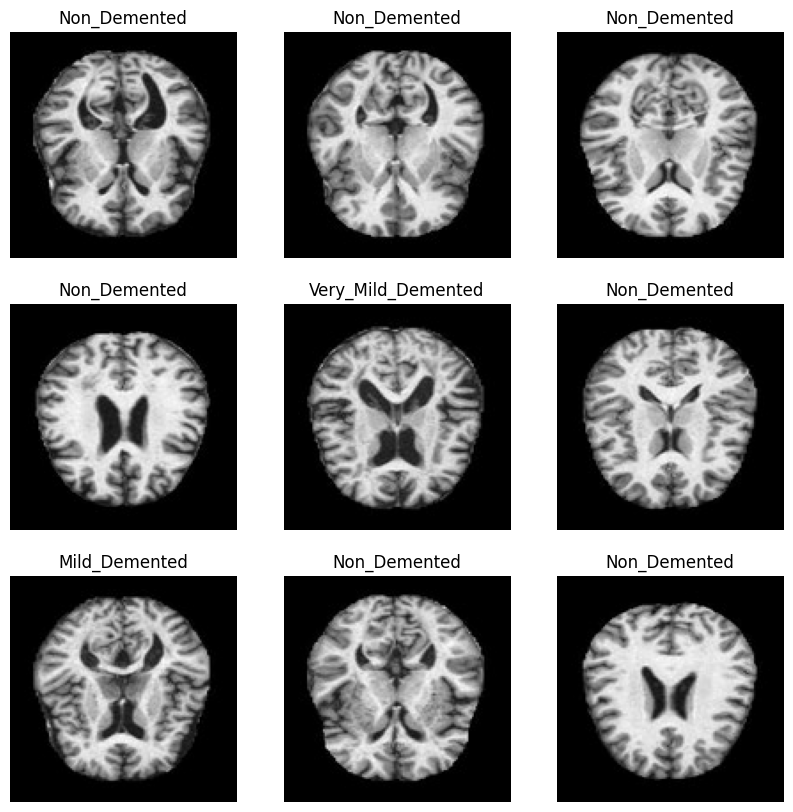

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

As an untrained person, it's not easy to see the difference in MRI scans for the different classes of dementia. Thankfully, it will take less time to train our CNN to see the differences than it would to train you!

Sometimes when training a model, you have more examples of one class than you do for another. That's the case in our data set:

<function matplotlib.pyplot.show(close=None, block=None)>

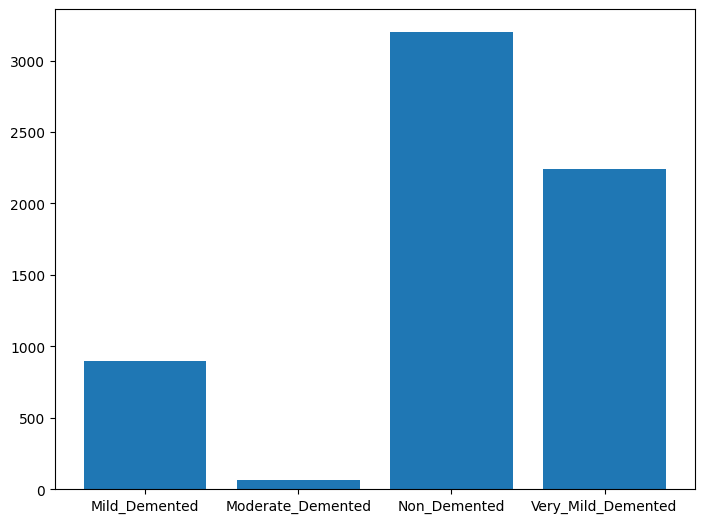

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [896,64,3200,2240]
ax.bar(class_names,size)
plt.show

# Building the Model

Our first step will be to create the convolutional base for our model. This base is made up of alternating convolutional layers and pooling layers.

*  [ Convolutional layers](https://developers.google.com/machine-learning/glossary/#convolutional-layer) (Conv2D in the code below) pass a two dimensional matrix (3x3 in the code below) along the input matrix (the RGB values of each 3x3 group of pixels in the input image) to produce a new matrix.
*    [Pooling layers](https://developers.google.com/machine-learning/glossary/#pooling) (MaxPooling2D in the code below) reduce the matrices produced by the convolutional layer to a smaller matrix, thereby condensing the information gained.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))

The dropout layers have the effect of adding noise to the training proces. They do this by randomly ignoring a fixed number of layer outputs. Adding dropout layers helps prevent overfitting in the model. 

Now we will add a flattening layer and a few dense layers. The flattening layer converts the data into a single long feature vector which feeds into the first of the dense layers. "Dense layer" is another term for a [fully connected layer](https://developers.google.com/machine-learning/glossary/#fully-connected-layer). In this model, the first two dense layers use a ReLU activation function, and the third (the output layer) uses a softmax activation function.



In [ ]:

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

Now that we have added all the layers, it's time to compile the model and have a look at the shapes of the layers.

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0

Note that the input layer takes our images in th eshape (None, 128, 128, 3), and gives an output in the shape of (None, 4). The number of outputs will equal the number of inputs, and each output will consist of one of four labels:
*    Non_Demented
*    Very_Mild_Demented
*    Mild_Demented
*    Moderate_Demented



#Training the Model

Now that the model has been built, we will train it with our training set, and test it against our validation set. To get the best results, we would continue running training epochs as long as feasibly possible or until the optimization function is either maximized (if optimizing for accuracy) or minimized (if optimizing for loss). For the purposes of this demonstration though, we will train the model for 25 epochs.

As the model trains, you should see both the accuracy (how well the model performs on the training data set) and the validation accuracy (how well the model performs on the validation data set) increase. You should also see the loss and validation loss decrease.

In [ ]:
hist = model.fit(train_ds,validation_data=val_ds,epochs=25, batch_size=64, verbose=1)


Epoch 1/25
72/72 [==============================] - 100s 1s/step - loss: 1.2171 - accuracy: 0.4723 - val_loss: 1.0748 - val_accuracy: 0.5475
Epoch 2/25
72/72 [==============================] - 94s 1s/step - loss: 0.9699 - accuracy: 0.5504 - val_loss: 0.8854 - val_accuracy: 0.6043
Epoch 3/25
72/72 [==============================] - 95s 1s/step - loss: 0.8603 - accuracy: 0.6028 - val_loss: 0.7881 - val_accuracy: 0.6564
Epoch 4/25
72/72 [==============================] - 97s 1s/step - loss: 0.7128 - accuracy: 0.6833 - val_loss: 0.6744 - val_accuracy: 0.6917
Epoch 5/25
72/72 [==============================] - 94s 1s/step - loss: 0.6333 - accuracy: 0.7199 - val_loss: 0.5292 - val_accuracy: 0.7807
Epoch 6/25
72/72 [==============================] - 92s 1s/step - loss: 0.4946 - accuracy: 0.7921 - val_loss: 0.4851 - val_accuracy: 0.7960
Epoch 7/25
72/72 [==============================] - 91s 1s/step - loss: 0.4122 - accuracy: 0.8323 - val_loss: 0.3922 - val_accuracy: 0.8512
Epoch 8/25
72/72 [=

Our model is now trained. Let's look at the way accuracy and loss changed over the 25 epochs of training.

In [ ]:
get_ac = hist.history['accuracy']
get_los = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

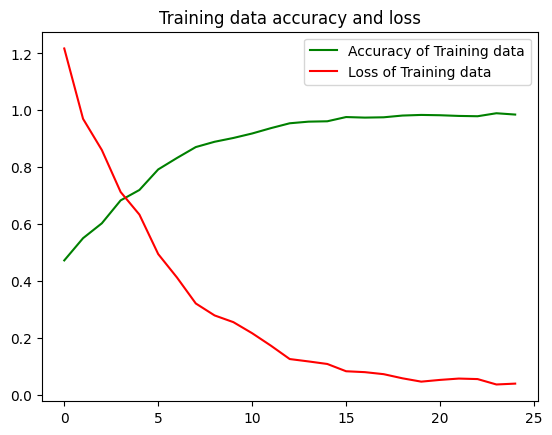

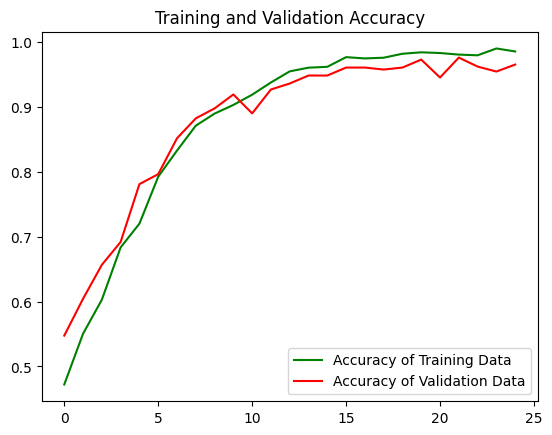

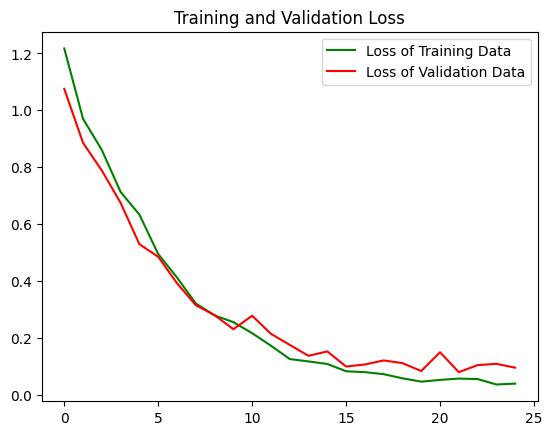

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

We trained our model for 25 epochs, but it's easy see that the gains in accuacy increase more rapidly in earlier epochs than they do in later epochs. Likewise, the decrease in loss evens out over time.  

Now that we have a trained model, let's put it to work. We will take 16 images at random from the testing set and see how the labels provided by the model compare to the labels given by medical professionals. Note that these images will be new to model; so far it has only worked with the images in the training and validation sets.

1/1 [==============================] - 0s 38ms/step


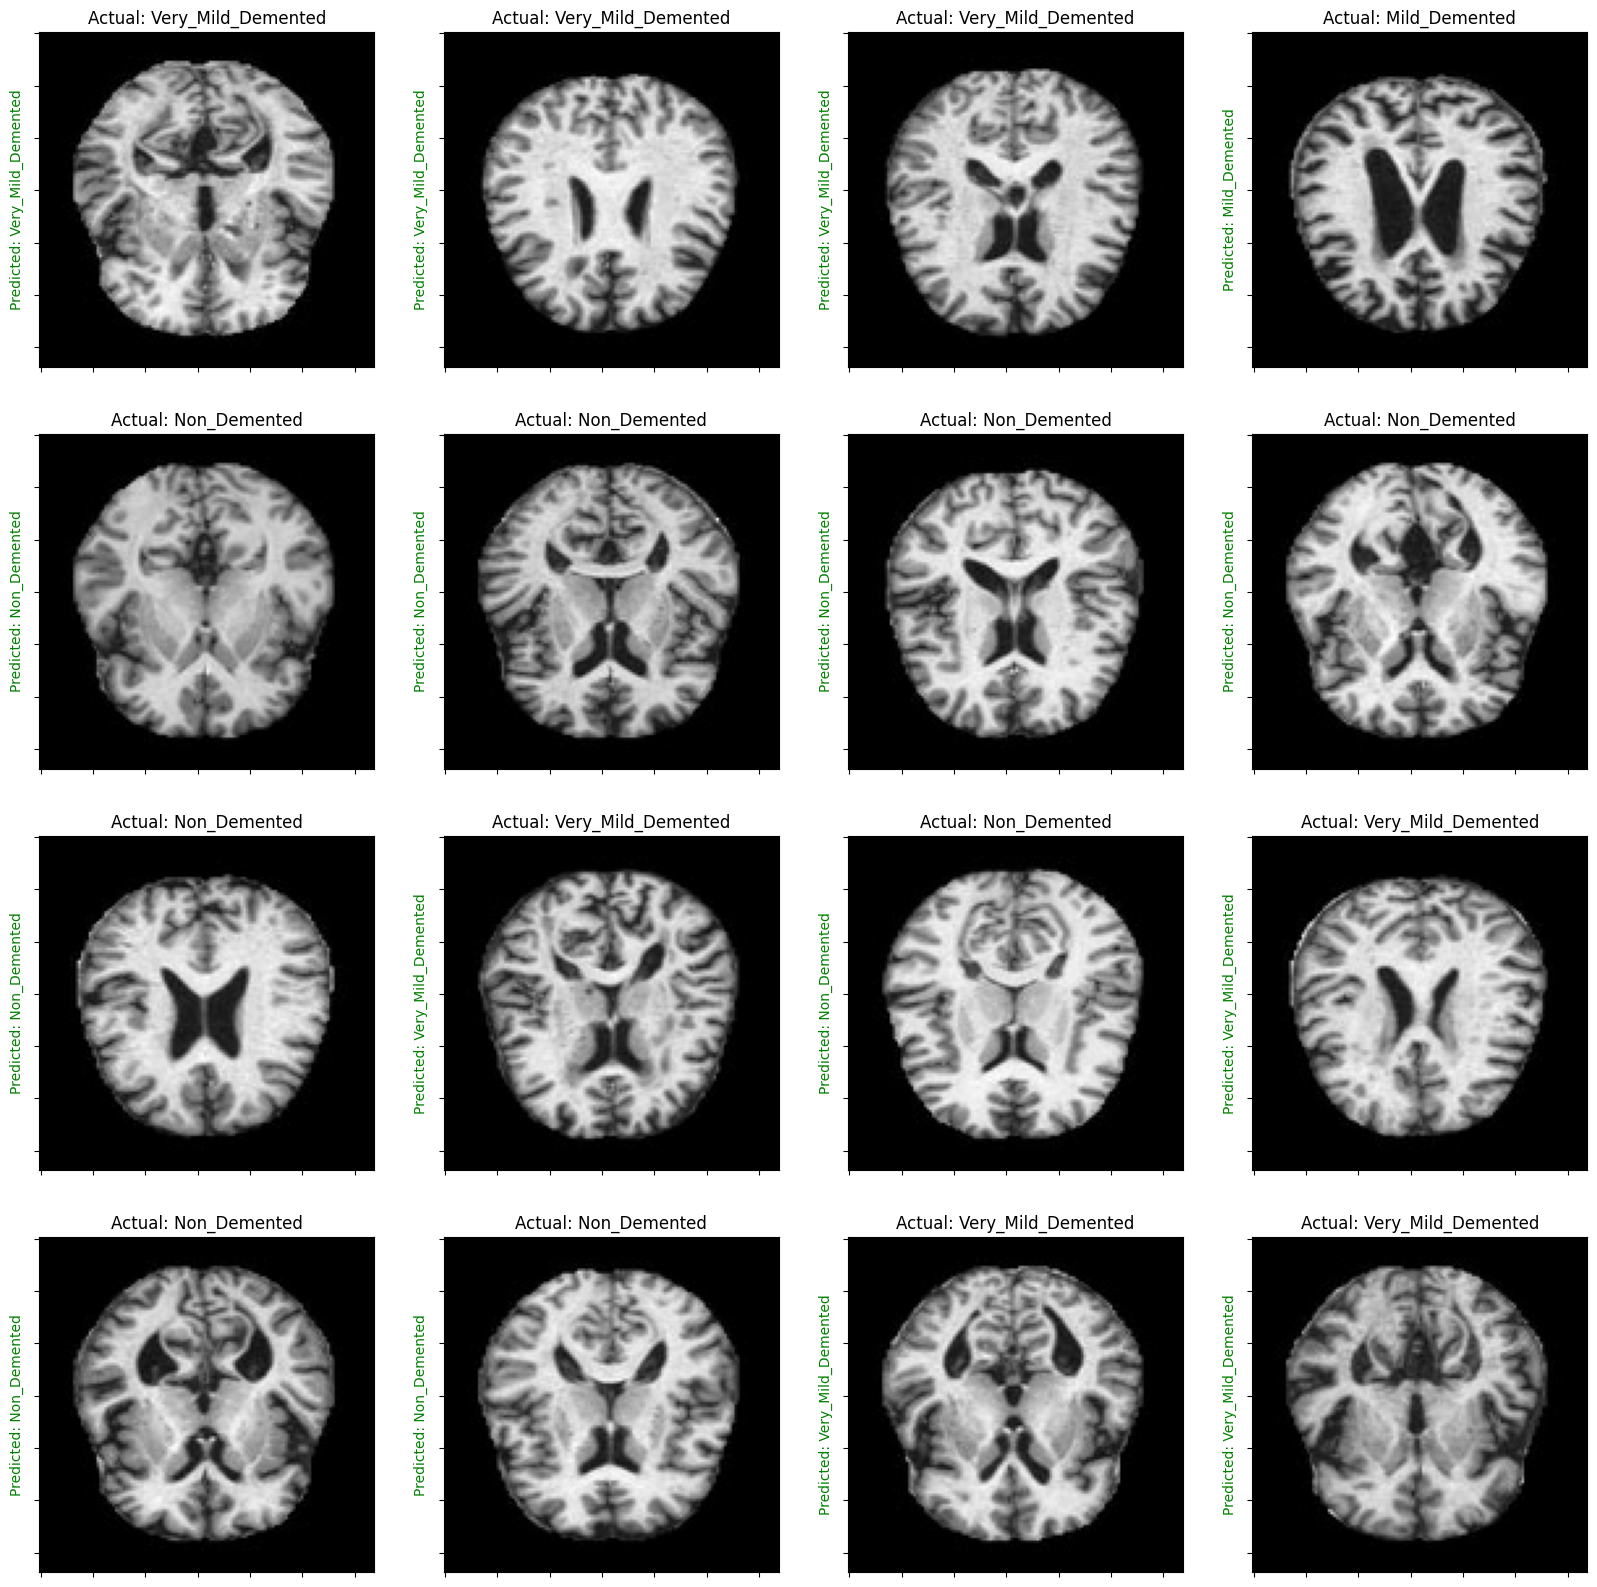

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])

Now let's see how the model does when evaluating all the images in the testing data set.

In [ ]:
loss, accuracy = model.evaluate(test_ds)

21/21 [==============================] - 9s 425ms/step - loss: 0.0732 - accuracy: 0.9793


In [ ]:
cm = tf.zeros((4,4), dtype=tf.int32)

for x_batch, y_batch in test_ds:
  y_pred_batch = model(x_batch)
  y_pred_batch = np.argmax(y_pred_batch, axis=1)
  batch_cm=tf.math.confusion_matrix(y_batch, y_pred_batch, num_classes = 4)
  cm += batch_cm

In [ ]:
cm


<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[169,   0,   1,  10],
       [  1,  37,   1,   0],
       [  0,   0, 630,  10],
       [  1,   0,   3, 444]], dtype=int32)>

Text(113.78159722222219, 0.5, 'Actual label')

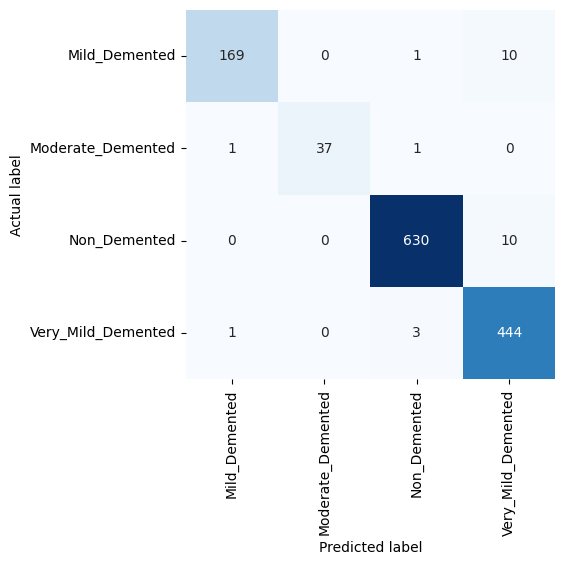

In [ ]:
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')